# Sparkify Project 

# Project Description

Sparkify is a music streaming service where users can listen to music with different subscription levels. The users with paid subscription can listen to songs ad-free whereas free subscription users will have to listen to ads. 

Users can upgrade to the paid subscription after the free trial or vice versa. Also, they can cancel their accounts. 


The objective of this project is to identify the users that will cancel their accounts. By predicting the customer churn rates helps the business gain a better understanding of future expected revenue. Also, identify and improve upon areas where service is lacking. 

For this project I have used Sparkify data to do an exploratory analysis, feature engineering on the features of interest that is used in different machine learning algorithms, and then determining the best performed model based on test accuracy and F1 score metrics. 


# Author 

### Raghad Alotaibi 

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

import pyspark
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, countDistinct, count, col
from pyspark.sql import Window


from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as fmax
import pyspark.sql.functions as f


import matplotlib.pyplot as plt  
import seaborn as sns


from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, LinearSVC, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()

spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load data 

sparkify = spark.read.load("/home/workspace/mini_sparkify_event_data.json", format="json")

In [4]:
# number of records 

sparkify.count()

286500

In [5]:
sparkify.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# showing top 2 rows

sparkify.show(n=2, truncate=False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+---------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song     |status|ts           |userAgent                                                                                                      |userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+---------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|Martha Tilston  |Logged In|Colin    |M     |50           |Freeman |277.89016|paid

In [7]:
# checking missing values 

sparkify = sparkify.na.drop(how="any", subset=['userId','sessionId'])
sparkify.count()

286500

In [8]:
sparkify = sparkify.filter(sparkify.userId!="").orderBy(["userId", "ts"], ascending=[True, True])
sparkify.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
# creating feature churn
churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType()) 
sparkify = sparkify.withColumn("churn", churn("page"))
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
sparkify = sparkify.withColumn("churn", Fsum("churn").over(window))

In [9]:
sparkify.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [11]:
sparkify.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,count,228108,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154,278154
1,mean,551.0852017937219,None,None,None,114.89918174824018,None,249.1171819778349,None,None,None,None,1.535358834085557E12,1042.5616241362698,Infinity,209.10321620397335,1.5409589154318582E12,None,59682.02278593872,0.16129194618808287
2,stddev,1217.7693079161377,None,None,None,129.85172939949013,None,99.23517921058327,None,None,None,None,3.2913216163273053E9,726.5010362219833,NaN,30.151388851327837,1.5068287123362303E9,None,109091.94999910559,0.36780068056308857
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10,0
4,max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99,1


In [10]:
# visualization 

def barplot(x_label,y_label,df,title,hue):
    '''
    Plots a seaborn barchart 
    input: 
        x_lable : Values to be displayed on x-axis
        y_label : Values to be displayed on y-axis
        df : Data to be plotted
        title : the chart title
        hue : the hue of the chart
    return: None
    '''
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.title(title,fontsize= 16)
    ax = sns.barplot(y=y_label, x=x_label, data=df.toPandas(), hue=hue)

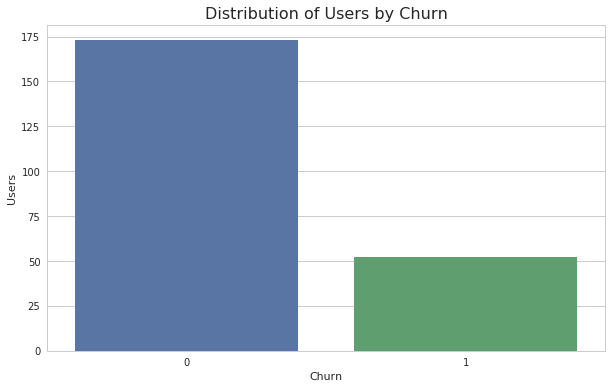

In [11]:
barplot(x_label="Churn",y_label="Users",df=sparkify.groupBy("Churn").agg(countDistinct("userId").alias("Users")), title='Distribution of Users by Churn',hue=None)

There are 77% of users are non-churners and 22% of churners. 

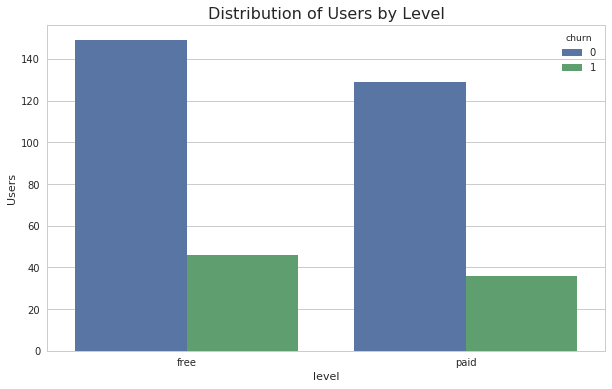

In [12]:
barplot(x_label="level", y_label="Users", df=sparkify.groupBy("level","churn").agg(countDistinct("userId").alias("Users")), title="Distribution of Users by Level", hue= "churn")

The majority of users have the free subscription plan and 24% of them churned, whereas, the churners in the paid subscription are 20%.   

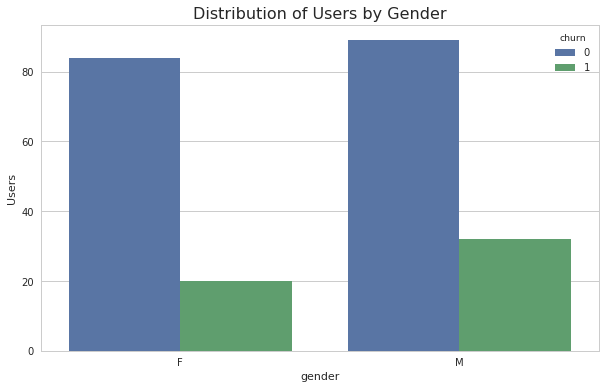

In [13]:
barplot(x_label="gender", y_label="Users", df=sparkify.groupBy("gender","churn").agg(countDistinct("userId").alias("Users")), title="Distribution of Users by Gender", hue= "churn")

About 54% of users were identified as males with a higher churn rate than female users. There was 20 female users who churned and 26% of male users churned.  


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [7]:
# droping unwanted features 
sparkify = sparkify.drop(*['firstName','lastName'])

In [8]:
# creating feature auth
feature_auth = sparkify.groupBy("userId").pivot('auth').agg(f.lit(1)).na.fill(0)
feature_auth = feature_auth.select([f.col(c).alias('auth'+"_"+c+"") if c not in 'userId' else c for c in feature_auth.columns])   

In [9]:
# creating feature gender
feature_gender = sparkify.groupBy("userId").pivot('gender').agg(f.lit(1)).na.fill(0)
feature_gender = feature_gender.select([f.col(c).alias('gender'+"_"+c+"") if c not in 'userId' else c for c in feature_gender.columns]) 

In [10]:
# creating feature level
feature_level = sparkify.groupBy("userId").pivot('level').agg(f.lit(1)).na.fill(0)
feature_level = feature_level.select([f.col(c).alias('level'+"_"+c+"") if c not in 'userId' else c for c in feature_level.columns]) 

In [11]:
# creating feature thumbsups
feature_thumbsup = sparkify.where(sparkify.page=='Thumbs Up') \
                                          .groupby(['userId']).agg(count(col('page'))\
                                          .alias('ThumbsUps'))\
                                          .orderBy('userId')\
                                          .select(['userId','ThumbsUps'])

In [12]:
# creating feature thumbsdowns
feature_thumbsdown = sparkify.where(sparkify.page=='Thumbs Down') \
                                            .groupby(['userId']).agg(count(col('page'))\
                                            .alias('ThumbsDowns')).orderBy('userId')\
                                            .select(['userId','ThumbsDowns'])

In [13]:
# creating feature songs
feature_songs = sparkify.where(sparkify.song!='null')\
                                       .groupby('userId').agg(count(sparkify.song)\
                                       .alias('Songs')).orderBy('userId') \
                                       .select(['userId','Songs'])

In [14]:
# creating feature artists
feature_artists = sparkify.filter(sparkify.page=='NextSong')\
                                         .select(['userId','artist'])\
                                         .groupBy(["userId"])\
                                         .agg(countDistinct("artist").alias("artists"))

In [15]:
# creating feature churn 
feature_churn = sparkify.groupBy("userId").agg(fmax("churn").alias("label"))

In [16]:
#creating df from created features above 

df = feature_auth.join(feature_gender,on='userId',how='inner').\
                            join(feature_level,on='userId',how='inner').\
                            join(feature_thumbsup,on='userId',how='inner').\
                            join(feature_thumbsdown,on='userId',how='inner').\
                            join(feature_songs,on='userId',how='inner').\
                            join(feature_artists,on='userId',how='inner').\
                            join(feature_churn,on='userId',how='inner')
                            


In [17]:
# dropping dublicates 
df = df.dropDuplicates()

In [18]:
df.limit(2).toPandas()

,userId,auth_Cancelled,auth_Logged In,gender_F,gender_M,level_free,level_paid,ThumbsUps,ThumbsDowns,Songs,artists,label
0,100010,0,1,1,0,1,0,17,5,275,252,0
1,200002,0,1,0,1,1,1,21,6,387,339,0


In [19]:
df.dtypes

[('userId', 'string'),
 ('auth_Cancelled', 'int'),
 ('auth_Logged In', 'int'),
 ('gender_F', 'int'),
 ('gender_M', 'int'),
 ('level_free', 'int'),
 ('level_paid', 'int'),
 ('ThumbsUps', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('Songs', 'bigint'),
 ('artists', 'bigint'),
 ('label', 'bigint')]

In [18]:
# converting datatype to int
for feature in df.columns[1:]:
    df = df.withColumn(feature,df[feature].cast('int'))

In [21]:
df.dtypes

[('userId', 'string'),
 ('auth_Cancelled', 'int'),
 ('auth_Logged In', 'int'),
 ('gender_F', 'int'),
 ('gender_M', 'int'),
 ('level_free', 'int'),
 ('level_paid', 'int'),
 ('ThumbsUps', 'int'),
 ('ThumbsDowns', 'int'),
 ('Songs', 'int'),
 ('artists', 'int'),
 ('label', 'int')]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

- include refinement

- model evaluation and validation
    - include justinfication 

In [19]:
# drop userId 

df.drop(*['userId'])

# split the data to training and testing sets 

training, test = df.randomSplit([0.8, 0.2], seed = 42)

# creating assebler
assembler = VectorAssembler(inputCols=["auth_Cancelled","auth_Logged In", "gender_F", "gender_M",\
                                       "level_free","level_paid","ThumbsUps","ThumbsDowns","Songs","artists"], \
                            outputCol='inputFeatures')

# creating scaler
scaler = Normalizer(inputCol="inputFeatures", outputCol="features")



# Logistic Regression

In [ ]:
# logistic regression 
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [ ]:
# logistic regression pipeline
lr_pipeline = Pipeline(stages=[assembler, scaler, lr]);

In [ ]:
# lr grid of parameters
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [1,5]) \
    .addGrid(lr.regParam, [0.0, 0.1, 0.01]) \
    .build()

In [ ]:
# lr corss validation with 2 folds
lr_crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

In [29]:
# fitting the lr model
lr_model = lr_crossval.fit(training)

In [ ]:
# lr prediction
lr_predict = lr_model.transform(test)

In [31]:
# lr evaluator
lr_evaluator = MulticlassClassificationEvaluator(labelCol ="label",predictionCol="prediction") 

In [32]:
# lr accuracy and f1 scores
lr_accuracy = lr_evaluator.evaluate(lr_predict, {lr_evaluator.metricName: "accuracy"})
lr_f1score = lr_evaluator.evaluate(lr_predict, {lr_evaluator.metricName: "f1"})
 
# printing lr results
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(lr_accuracy))
print('F-1 Score:{}'.format(lr_f1score))



Logistic Regression Metrics:
Accuracy: 0.7096774193548387
F-1 Score:0.616525789201311


# Support Verctor Machine

In [ ]:
# support vector machine
svm = LinearSVC(maxIter=10)

In [ ]:
# svm pipeline
svm_pipeline = Pipeline(stages=[assembler, scaler, svm]);

In [ ]:
# svm grid of parameters
svm_paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [1, 5]) \
    .build()

In [ ]:
# svm cross validation with 2 folds
svm_crossval = CrossValidator(estimator=svm_pipeline,
                          estimatorParamMaps=svm_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

In [33]:
# fitting svm model
svm_model = svm_crossval.fit(training)

In [34]:
# svm prediction
svm_predict = svm_model.transform(test)

In [35]:
# svm evaluator
svm_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

In [36]:
#svm accuracy & f1 scores
svm_accuracy = svm_evaluator.evaluate(svm_predict, {svm_evaluator.metricName: "accuracy"})
svm_f1score = svm_evaluator.evaluate(svm_predict, {svm_evaluator.metricName: "f1"})

# printing svm results
print('SupportVectorMachine Metrics:')
print('Accuracy: {}'.format(svm_accuracy))
print('F-1 Score:{}'.format(svm_f1score))
 


SupportVectorMachine Metrics:
Accuracy: 0.6774193548387096
F-1 Score:0.5471464019851118


- evaluate accuracy 
    - detrmine winning model based on accuracy 
- measure F1 score 

# Naïve Bayes 

In [40]:
# naive bayes
nb = NaiveBayes()

In [41]:
# nb pipeline
nb_pipeline = Pipeline(stages=[assembler, scaler, nb]);

In [43]:
# nb grid of parameters
nb_paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [1.0]) \
    .build()

In [44]:
# nb cross validation with 2 folds
nb_crossval = CrossValidator(estimator=nb_pipeline,
                          estimatorParamMaps=nb_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

In [45]:
# fitting nb model
nb_model = nb_crossval.fit(training)

In [46]:
# nb predictions
nb_predict = nb_model.transform(test)

In [47]:
# nb evaluator
nb_evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction")

In [48]:
# nb accuracy score
nb_accuracy = nb_evaluator.evaluate(nb_predict, {nb_evaluator.metricName: "accuracy"})

In [49]:
# nb f1 score
nb_f1score = nb_evaluator.evaluate(nb_predict, {nb_evaluator.metricName: "f1"})

In [50]:
# printing nb accuracy and f1 results
print('Accuracy: {}'.format(nb_accuracy))
print('F-1 Score: {}'.format(nb_f1score))

Accuracy: 0.6774193548387096
F-1 Score: 0.5471464019851118


# Conclusion

- reflection 
- improvemnts 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.